## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [2]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string, gensim
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [3]:
filepath = "/content/drive/MyDrive/Colab Notebooks/NLPAssignment/data/complaints.json" # Write the path to your data file and load it
with open(filepath) as f:
    data = json.load(f)# returns JSON object as a dictionary 
df=pd.json_normalize(data)
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


## Data preparation

In [4]:
# Inspect the dataframe to understand the given data.
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [5]:
#print the column names
print(df.columns)

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')


In [6]:
#Assign new columns names
df.columns = [i[1:] for i in df.columns]
df.columns = list(df.columns[:4]) + [i.split('.')[1] for i in df.columns[4:]]


In [7]:
df.columns

Index(['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely',
       'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'],
      dtype='object')

In [8]:
#Assign nan in place of blanks in the complaints column
pattern = r"^\s*$"
value = np.NaN
df.complaint_what_happened = df.complaint_what_happened.replace(pattern, value, regex=True)
df.head()


,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,NaN,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,NaN,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,NaN,Charged too much interest,N/A


In [9]:
#Remove all rows where complaints column is nan
non_null_indices = np.where(~pd.isnull(df.complaint_what_happened))[0]
non_null_indices


array([    1,     2,    10, ..., 78310, 78311, 78312])

In [10]:
df = df.iloc[non_null_indices]
df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XX...",Information belongs to someone else,Consent provided
14,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,N/A,Checking or savings account,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$1600.00} i de...,Funds not handled or disbursed as instructed,Consent provided


## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Use POS tags to get relevant words from the texts.


In [13]:
complaints = df.complaint_what_happened.reset_index(drop=True).values
complaints

array(['Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.',
       'I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX   changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.',
       'Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to 

In [11]:
# Write your function here to clean the text and remove all the unnecessary elements.
def preprocess(sent):    
    # remove all numeric characters
    new = re.sub('X*', '', sent)
    # remove any text within square brackets
    new = re.sub('[^A-z\s*]', '', new)
    # remove punctuation marks
    new = re.sub(r'[^\w\s]', '', new)
    # convert the text to lower case
    new = new.lower()
    # tokenize all the words
    new = nltk.word_tokenize(new)
    return new

In [30]:
#Write your function to Lemmatize the texts
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize(sent):
    #lemmatize the words
    # lemmetize the words
    new = [lemmatizer.lemmatize(word=i) for i in sent if i not in nltk.corpus.stopwords.words('english')]
    # join all the words to form the sentence again
    new = ' '.join(new)
    return new

In [15]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [17]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [28]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
clean_complaints = [preprocess(sentence) for sentence in complaints]

In [31]:
lemmatized_complaints = [lemmatize(sentence) for sentence in clean_complaints]

In [32]:
model = spacy.load("en_core_web_sm")

In [33]:
#Write your function to extract the POS tags 
def getNounTokens(sent):
    docs = model(sent)
    tokens = [token.text for token in docs if token.pos_=='NOUN']
    return tokens


In [46]:
noun_complaints = [getNounTokens(sentence) for sentence in clean_complaints]

In [47]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean = pd.DataFrame({'clean_complaints':clean_complaints})
df_clean['lemmatized_complaints'] = lemmatized_complaints
df_clean['noun_complaints'] = noun_complaints

In [48]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21072 entries, 0 to 21071
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   clean_complaints       21072 non-null  object
 1   lemmatized_complaints  21072 non-null  object
 2   noun_complaints        21072 non-null  object
dtypes: object(3)
memory usage: 494.0+ KB


In [49]:
df_clean.head()

,clean_complaints,lemmatized_complaints,noun_complaints
0,good morning name appreciate could help put st...,g r n n g n e p p r e c e c u l h e ...,"[morning, name, appreciate, chase, debt, verif..."
1,upgraded card told agent upgrade anniversary d...,u p g r e c r l g e n u p g r e n n ...,"[card, agent, anniversary, date, agent, inform..."
2,chase card reported however fraudulent applica...,c h e c r r e p r e h w e v e r f r u ...,"[card, application, identity, consent, service..."
3,trying book ticket came across offer applied t...,r n g b k c k e c e c r f f e r p ...,"[book, ticket, offer, ticket, reward, card, in..."
4,grand son give check deposit chase account fun...,g r n n g v e c h e c k e p c h e ...,"[son, check, account, money, son, money, pay, ..."


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




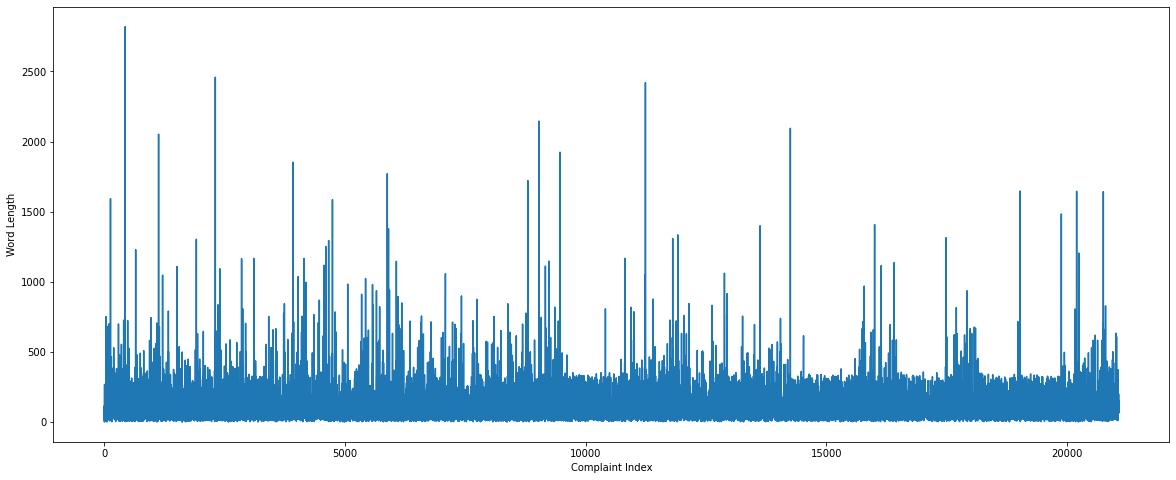

In [43]:
# Write your code here to visualise the data according to the 'Complaint' character length
plt.figure(figsize=(20,8))
plt.plot([len(i.split()) for i in df_clean['clean_complaints']])
plt.xlabel('Complaint Index')
plt.ylabel('Word Length')
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

In [59]:
words = [word for word_list in df_clean['noun_complaints'] for word in word_list]


In [60]:
len(words)

999012

In [61]:
nltk.FreqDist(words).most_common(10)

[('account', 42678),
 ('chase', 39303),
 ('credit', 30784),
 ('card', 29748),
 ('payment', 20712),
 ('time', 15769),
 ('charge', 12401),
 ('money', 11621),
 ('day', 11414),
 ('check', 10195)]

In [64]:
WORD_DIST = pd.DataFrame(nltk.FreqDist(words).items() ,columns = ['word','WordCount'])
WORD_DIST = WORD_DIST.set_index('word')

In [66]:
WORD_DIST.sort_values(by='WordCount',ascending=False).head(40)

,WordCount
word,
account,42678
chase,39303
credit,30784
card,29748
payment,20712
time,15769
charge,12401
money,11621
day,11414


In [73]:
wordcloud = WordCloud(background_color = 'black', width = 800, height = 400,
                      colormap = 'viridis', max_words = 180, contour_width = 3,
                      max_font_size = 80, contour_color = 'steelblue',
                      random_state = 0, collocations = False)

In [68]:
most_freq = WORD_DIST.sort_values(by='WordCount',ascending=False).head(40).index

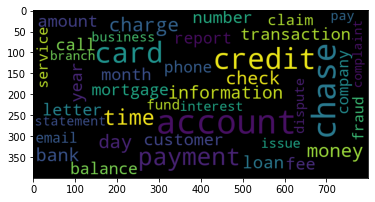

In [74]:
from nltk import collocations
wordcloud.generate(' '.join([w for w in words if w in most_freq.tolist()]))
plt.imshow(wordcloud)

In [ ]:
#Removing -PRON- from the text corpus
# df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')
# PRON are already excluded

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [76]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
vectorizer = CountVectorizer(ngram_range = (1,1))
X1 = vectorizer.fit_transform(df_clean['clean_complaints']) 
features = (vectorizer.get_feature_names_out())
# Getting top ranking features
sums = X1.sum(axis = 0)
data1 = []
for col, term in enumerate(features):
    data1.append( (term, sums[0,col] ))
ranking = pd.DataFrame(data1, columns = ['term','rank'])
words = (ranking.sort_values('rank', ascending = False))
print ("\n\nWords head : \n", words.head(30))



Words head : 
               term   rank
4392         chase  80588
254        account  48635
6353        credit  33108
3884          card  30546
2522          bank  28251
19214      payment  21186
29958        would  20323
27224         told  16381
27063         time  16054
3731        called  13411
4345        charge  13338
6768           day  13265
21628     received  12863
16808        money  11962
4526         check  11801
2378          back  11353
3723          call  11349
15464         loan  10993
23582         said  10885
17415        never   9949
15196       letter   9688
13611  information   9660
15761         made   9317
6145         could   9268
11565          get   9240
10326          fee   8957
27439  transaction   8660
17967       number   8634
16862        month   8574
1142          also   8540


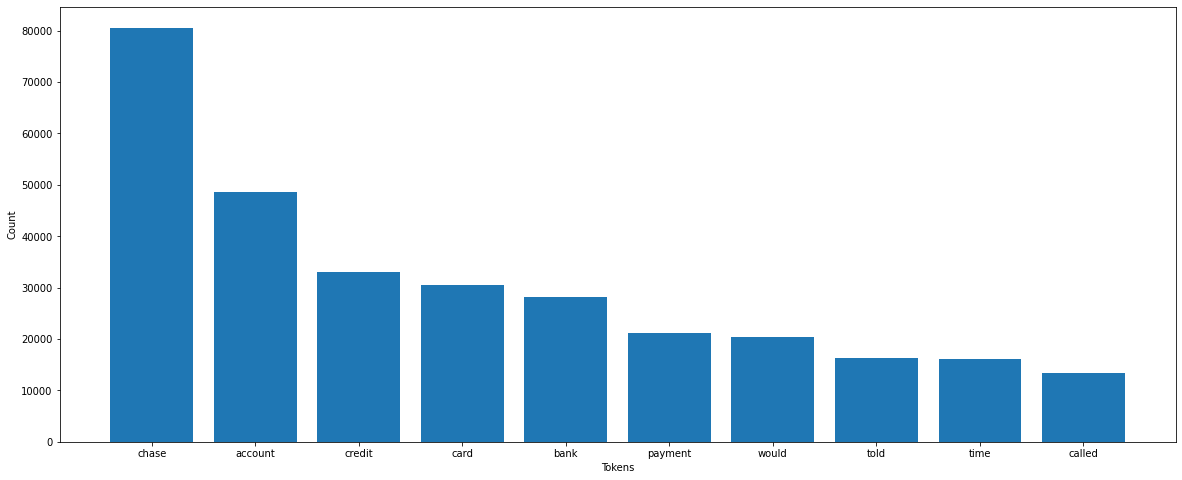

In [77]:
#Print the top 10 words in the unigram frequency
plt.figure(figsize=(20,8))
plt.bar(words.term.iloc[:10], words.iloc[:10]['rank'])
plt.xlabel('Tokens')
plt.ylabel('Count')
plt.show()


In [78]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
vectorizer = CountVectorizer(ngram_range = (2,2))
X1 = vectorizer.fit_transform(df_clean['clean_complaints']) 
features = (vectorizer.get_feature_names_out())
  
# Getting top ranking features
sums = X1.sum(axis = 0)
data1 = []
for col, term in enumerate(features):
    data1.append( (term, sums[0,col] ))
ranking = pd.DataFrame(data1, columns = ['term','rank'])
words = (ranking.sort_values('rank', ascending = False))
print ("\n\nWords head : \n", words.head(30))



Words head : 
                     term   rank
127284        chase bank  12800
182827       credit card  12794
183894     credit report   3869
134395  checking account   3749
105080      called chase   3716
189041  customer service   3067
381973         jp morgan   2889
127877      chase credit   2523
450843      morgan chase   2480
5454       account chase   2385
197230        debit card   2038
76255       bank account   1952
5501      account closed   1814
166786   contacted chase   1754
183995      credit score   1699
519221        phone call   1634
255988       even though   1581
127506        chase card   1572
571843   received letter   1464
126907     chase account   1424
142981    closed account   1396
390872      late payment   1391
182800     credit bureau   1308
782378        would like   1298
464630    never received   1287
142408     close account   1284
371578     interest rate   1275
110889        card chase   1263
100291      business day   1254
110481      card accoun

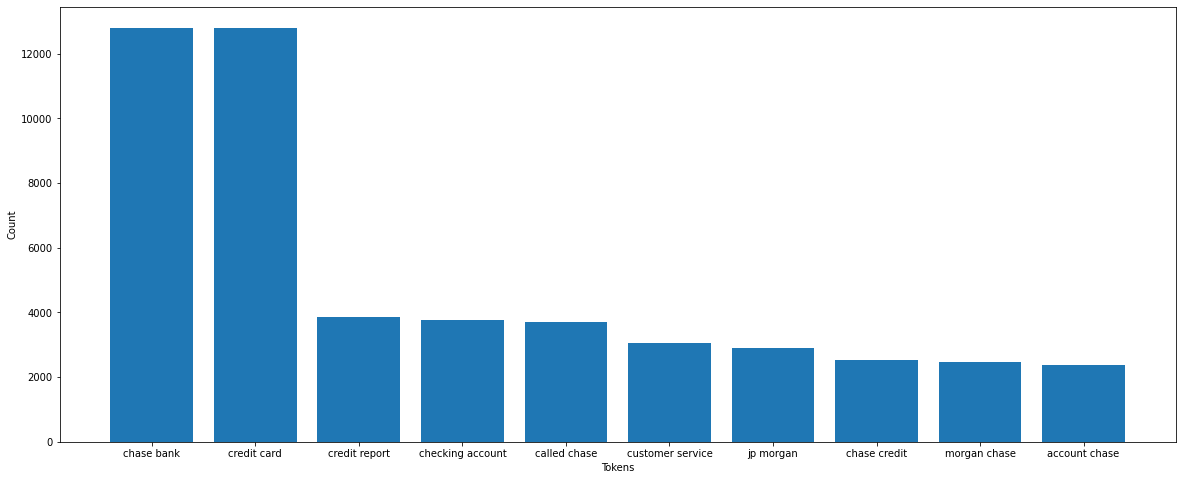

In [79]:
#Print the top 10 words in the bigram frequency
plt.figure(figsize=(20,8))
plt.bar(words.term.iloc[:10], words.iloc[:10]['rank'])
plt.xlabel('Tokens')
plt.ylabel('Count')
plt.show()

In [80]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
vectorizer = CountVectorizer(ngram_range = (3,3))
X1 = vectorizer.fit_transform(df_clean['clean_complaints']) 
features = (vectorizer.get_feature_names_out())
  
# Getting top ranking features
sums = X1.sum(axis = 0)
data1 = []
for col, term in enumerate(features):
    data1.append( (term, sums[0,col] ))
ranking = pd.DataFrame(data1, columns = ['term','rank'])
words = (ranking.sort_values('rank', ascending = False))
print ("\n\nWords head : \n", words.head(30))



Words head : 
                                     term  rank
903753                   jp morgan chase  2369
339345                 chase credit card  2246
481774               credit card account   969
482088               credit card company   956
482046                 credit card chase   715
1062303                morgan chase bank   677
14878                 account chase bank   644
339725            chase customer service   581
1340144            received letter chase   477
336855            chase checking account   446
258816                 called chase bank   444
870472             inquiry credit report   429
379584            checking account chase   405
489737           credit reporting agency   390
904890               jpmorgan chase bank   372
758873                    get money back   371
259752           called customer service   370
331459                chase bank account   369
1534183           social security number   357
670886             fair credit reporting   

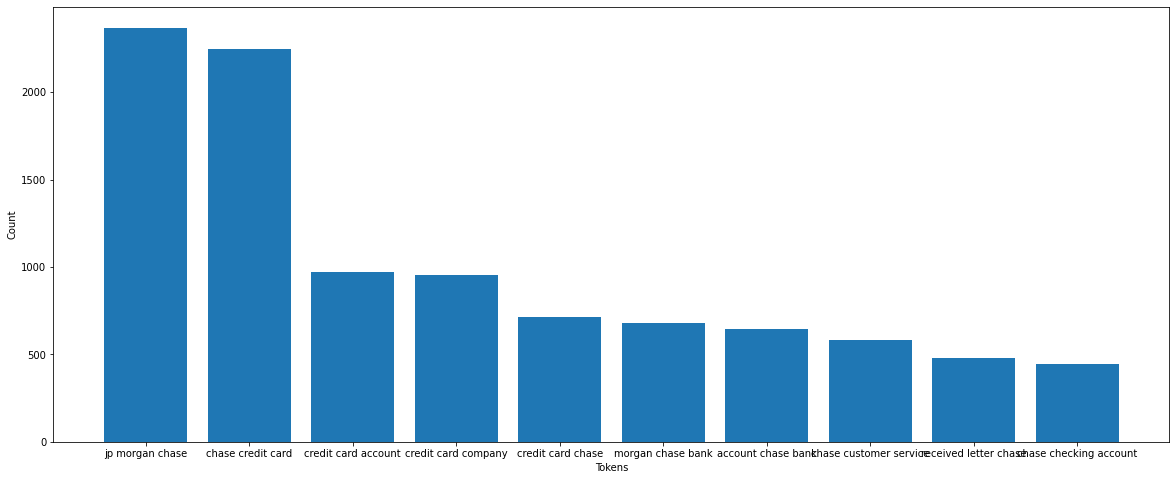

In [81]:
#Print the top 10 words in the trigram frequency
plt.figure(figsize=(20,8))
plt.bar(words.term.iloc[:10], words.iloc[:10]['rank'])
plt.xlabel('Tokens')
plt.ylabel('Count')
plt.show()

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [ ]:
#df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')
# Already removed.

In [ ]:
#All masked texts has been removed
df_clean

## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [82]:
#Write your code here to initialise the TfidfVectorizer 

vectorizer = TfidfVectorizer(ngram_range=(1,2), max_df=0.6)

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [83]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = vectorizer.fit_transform(df_clean['clean_complaints'])

In [ ]:
pd.DataFrame(dtm.toarray(), columns=vectorizer.get_feature_names_out())

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [ ]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [ ]:
from sklearn.decomposition import NMF

In [ ]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40)

In [ ]:
W1 = nmf_model.fit_transform(dtm)
H1 = nmf_model.components_
len(vectorizer.get_feature_names_out())

In [ ]:
W1

In [ ]:
H1

In [ ]:
#Print the Top15 words for each of the topics
num_words = 15

vocab = np.array(vectorizer.get_feature_names_out())
top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_words:-1]]
topic_words = [top_words(t) for t in H1]
topics = [' '.join(t) for t in topic_words]

topics


In [ ]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4



In [ ]:
#Assign the best topic to each of the cmplaints in Topic Column

df = df_clean['clean_complaints']
df['topic'] = [np.argmax(i) for i in W1]

In [ ]:
df_clean['clean_complaints']

['good morning name appreciate could help put stop chase bank cardmember service wrote chase asking debt verification sent statement acceptable asking bank validate debt instead receiving mail every month attempting collect debt right know information consumer chase account thanks advance help',
 'upgraded card told agent upgrade anniversary date would change turned agent giving wrong information order upgrade account changed anniversary date without consent recording agent misled',
 'chase card reported however fraudulent application submitted identity without consent fraudulently obtain service extend credit without verifying identity applicant',
 'trying book ticket came across offer applied towards ticket applied reward card put information offer within le minute notified via screen decision could made immediately contacted referred chase bank immediately contacted chase bank within minute getting notification screen told chase representative spoke application denied could state as

In [ ]:
#Print the first 5 Complaint for each of the Topics
df.groupby('topic').head(5).sort_values('topic')

,complaints,topic
0,good morning name appreciate could help put st...,0
8,made payment online retailer using chase quick...,0
6,notice jp morgan chase restricted account debi...,0
4,grand son give check deposit chase account fun...,0
12,opened account chase bank used code bonus call...,0
14,chase amazon card declined catering order plac...,1
2,chase card reported however fraudulent applica...,1
1,upgraded card told agent upgrade anniversary d...,1
9,chase credit card incorrectly reporting data c...,1
21,senior citizen scammed several company paid ti...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [ ]:
#Create the dictionary of Topic names and Topics
Topic_names = {0:'Bank Account services', 1:'Credit card or prepaid card', 2:'Theft/Dispute Reporting', 3:'Mortgage/Loan', 4:'Others'}
#Replace Topics with Topic Names
df['topic'] = df['topic'].map(Topic_names)


In [ ]:
df_clean['clean_complaints']

['good morning name appreciate could help put stop chase bank cardmember service wrote chase asking debt verification sent statement acceptable asking bank validate debt instead receiving mail every month attempting collect debt right know information consumer chase account thanks advance help',
 'upgraded card told agent upgrade anniversary date would change turned agent giving wrong information order upgrade account changed anniversary date without consent recording agent misled',
 'chase card reported however fraudulent application submitted identity without consent fraudulently obtain service extend credit without verifying identity applicant',
 'trying book ticket came across offer applied towards ticket applied reward card put information offer within le minute notified via screen decision could made immediately contacted referred chase bank immediately contacted chase bank within minute getting notification screen told chase representative spoke application denied could state as

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [ ]:
#Create the dictionary again of Topic names and Topics

Topic_names = {0:'Bank Account services', 1:'Credit card or prepaid card', 2:'Theft/Dispute Reporting', 3:'Mortgage/Loan', 4:'Others'}
#Replace Topics with Topic Names
df['topic'] = df['topic'].map(Topic_names)

In [ ]:
df

,complaints,topic
0,good morning name appreciate could help put st...,Bank Account services
1,upgraded card told agent upgrade anniversary d...,Credit card or prepaid card
2,chase card reported however fraudulent applica...,Credit card or prepaid card
3,trying book ticket came across offer applied t...,Others
4,grand son give check deposit chase account fun...,Bank Account services
...,...,...
995,multiple unauthorized atm debit transaction ma...,Bank Account services
996,trying collect debt took property attorney ord...,Theft/Dispute Reporting
997,problem arose tried change bank account monthl...,Theft/Dispute Reporting
998,l ast two month chase w ebsite work intermitte...,Theft/Dispute Reporting


In [ ]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [ ]:
train,test = train_test_split(df, stratify=df['topic'], train_size=0.7, random_state=100)
X_train,y_train = train.complaints,train.topic
X_test,y_test = test.complaints,test.topic

In [ ]:
training_data

####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [ ]:

#Write your code to get the Vector count

#Write your code here to transform the word vector to tf-idf
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [ ]:
# Write your code here to build any 3 models and evaluate them using the required metrics

lr = LogisticRegression(random_state=40)
folds = KFold(n_splits=5, shuffle=True, random_state=True)
cv = cross_val_score(estimator=lr, X=X_train_tfidf, y=y_train, scoring='accuracy', cv=folds, n_jobs=-1)
cv.mean()



0.8385714285714284

In [ ]:
dt = DecisionTreeClassifier(random_state=50)
cv = cross_val_score(estimator=dt, X=X_train_tfidf, y=y_train, scoring='accuracy', cv=folds, n_jobs=-1)
cv.mean()

0.6928571428571428

In [ ]:
rf = RandomForestClassifier(random_state=50)
cv = cross_val_score(estimator=rf, X=X_train_tfidf, y=y_train, scoring='accuracy', cv=folds, n_jobs=-1)
cv.mean()

0.7928571428571428

In [ ]:
lr.fit(X_train_tfidf, y_train)
y_test_pred = lr.predict(X_test_tfidf)
print(classification_report(y_test, y_test_pred))

                             precision    recall  f1-score   support

      Bank Account services       0.83      0.94      0.88       102
Credit card or prepaid card       0.84      0.89      0.87        76
              Mortgage/Loan       1.00      0.50      0.67        28
                     Others       1.00      0.56      0.72        25
    Theft/Dispute Reporting       0.86      0.94      0.90        69

                   accuracy                           0.86       300
                  macro avg       0.91      0.77      0.81       300
               weighted avg       0.87      0.86      0.85       300

